[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/deep-learning/anns/iris_multiple_classifier.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# Perceptron neural network for multiclass classification

We will now use a simple Perceptron NN for multiple classification using the [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set). In this case, we have four input features (sepal length, sepal width, petal length, and petal width) and three output classes (setosa, versicolor, and virginica). Therefore, our neural network will follow the next architecture (with 4 inputs and 3 outputs):

<img src="img/iris_multiple_classifier.png" width="600px"/>

*Important*: This ANN returns three different binary classifiers (one for each type of iris) whether the input is setosa, versicolor and virginica. This is a multilabel classification problem (not a multiclass one). That is, the output can be more than one class at the same time. This is because of the simple architecture of the neural network were are using. In a multiclass classification problem, the output can only be one class at a time. We will see hot to solve this problem in another notebook.

In [1]:
# make sure the required packages are installed
%pip install pandas numpy seaborn matplotlib scikit-learn keras tensorflow --quiet
repo='data-science-course'
module='deep-learning/anns'
# if running in colab, install the required packages and copy the necessary files
if get_ipython().__class__.__module__.startswith('google.colab'):
    import os
    if not os.path.exists(repo):
        !git clone --filter=blob:none --sparse https://github.com/francisco-ortin/data-science-course.git 2>/dev/null
        !cd {repo} && git sparse-checkout init --cone && git sparse-checkout set {module}  2>/dev/null
    !cp --update {repo}/{module}/*.py . 2>/dev/null
    !mkdir -p img data
    !mv {repo}/{module}/img/* img/. 2>/dev/null
    !mv {repo}/{module}/data/* data/. 2>/dev/null

from keras.src.layers import Dense
from keras.src.optimizers import SGD
from sklearn.datasets import load_iris
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import numpy as np

from utils import show_history

Note: you may need to restart the kernel to use updated packages.


## Data preparation
We load the iris dataset. Then we create the `X` (independent variables) and `y` (dependent variable) dataframes. Finally, `iris_df` holds both X and y in the same dataframe.

In [2]:
# Load Iris Data
iris = load_iris()
# Creating pd DataFrames
X_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
y_df = pd.DataFrame(data=iris.target, columns=['species'])

We transform the species feature `y` into one-hot encoding: instead of a feature with 3 possible values, we have 3 different binary features: species_0, species_1 and species_2. Then, we concatenate `X_df` and `y_df` and we show the whole dataset (notice the one-hot encoding for species).

In [3]:
y_one_hot = pd.get_dummies(y_df['species'], prefix='species').map(lambda boolean: 1 if boolean else 0)
iris_df = pd.concat([X_df, y_one_hot], axis=1)
print(iris_df.describe())

       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)   species_0   species_1   species_2  
count        150.000000  150.000000  150.000000  150.000000  
mean           1.199333    0.333333    0.333333    0.333333  
std            0.762238    0.472984    0.472984    0.472984  
min            0.100000    0.000000    0.000000    0.000000  
25%            0.300000    0.000000    0.000000    0.000000  
50%            1.300000    0.000000    0.0

We prepare our X and y dataframes. In this case, y has three variables (one for each type of flower).

In [4]:
y_column_names = ['species_0', 'species_1', 'species_2']
# X is the dataset without the target variable (species)
X = iris_df.drop(labels=y_column_names, axis=1)
# y is species_0, species_1 and species_3 (three different classes / outputs)
y = iris_df[['species_0', 'species_1', 'species_2']]

Then, we split the dataset in 80% train and 20% test.

In [5]:
# Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Neural network

A simple neuron is created with 4 inputs and 3 outputs.  A sigmoid activation function is required for each output because we have three binary classifiers. The network has 3 neurons (one for each output) with 5 parameters each (4 inputs + bias): 3 output neurons * (4 weights for inputs + bias). All the parameters all trainable (learned) from data.

In [6]:
model = Sequential()
model.add(Dense(3, input_dim=4, activation='sigmoid'))
model.summary()  # params=15: 3 output neurons * (4 weights for inputs + bias)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 15        
                                                                 
Total params: 15 (60.00 Byte)
Trainable params: 15 (60.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We  use binary cross entropy as the loss function, since we are building three binary classifiers. For optimization, we use Stochastic Gradient Descent (SGD). We want to be prompted loss (binary cross entropy) and accuracy. 

In [7]:
model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])

We now train the model (learn the parameters) for 300 epochs. 

In [8]:
history = model.fit(X_train, y_train, epochs=300, 
                    verbose=0)  # verbose=0, no output (too many epochs)

Let's plot the training loss and accuracy for the training dataset:

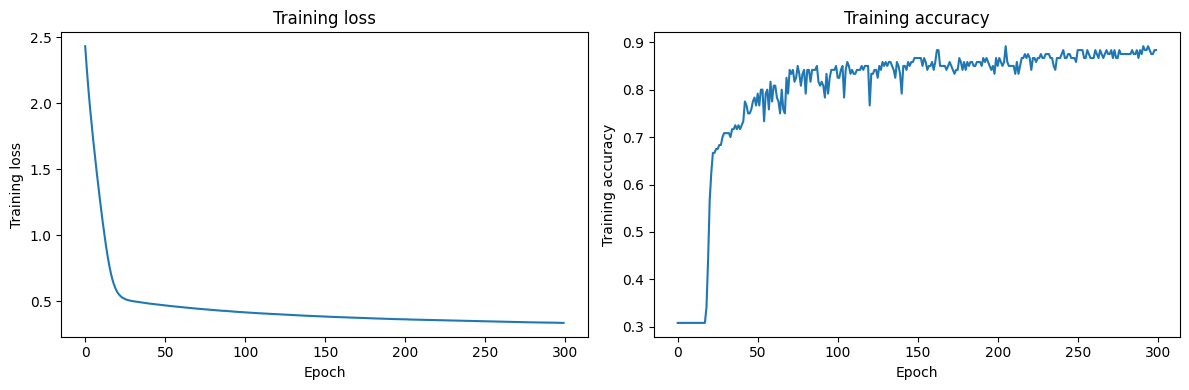

In [9]:
show_history(history, loss_label='Training loss', accuracy_label='Training accuracy')

## Prediction

We apply the neural network to the test dataset (forward propagation). That returns three probabilities, one for each class of iris.

Next, we have to assign the class with the highest probability because it cannot occur that one flower has more than one type (or no type at all). That is, we are actually dealing with a *multiclass* classification problem (not a multilabel one: a multilabel classifier allows an instance to belong to different classes simultaneously). *Notice*: In future notebooks, we will see how to make the three outputs sum 0, converting it into a multiclass classification problem.

Finally, we show the predictions for the test set.

In [13]:
prediction_probabilities = model.predict(X_test, verbose=0)
# function that, given a row, replaces 1 for its highest value and 0 for the rest (selects the highest value)
max_value_per_row = lambda row: [1 if i == max(row) else 0 for i in row]
# selects as the predicted class the one with the highest probability
predictions = np.apply_along_axis(arr=prediction_probabilities, func1d=max_value_per_row, axis=1)
print(f"Predictions for the test set:\n{predictions}")

Predictions for the test set:
[[0 1 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]


### Assessment
We show accuracy test set.

In [11]:
print(f"Accuracy: {accuracy_score(y_test, predictions):.4f}.")

Accuracy: 0.7000.


## $F_1$-score
If we want to compute $F_1$-score for multiclass classifiers, there are two ways of doing it:
1. *Micro $F_1$*: Calculates precision, recall, and $F_1$-score globally by counting the total true positives, false positives, and false negatives across all classes. This is suitable when there is a significant class imbalance, as it gives equal importance to each class, regardless of its frequency.
2. *Macro $F_1$*: Calculates precision, recall, and $F_1$-score for each class individually. Then, it averages these scores across all the classes.

In [12]:
print(f"F1-score micro: {f1_score(y_test, predictions, average='micro'):.4f}.")
print(f"F1-score macro: {f1_score(y_test, predictions, average='macro'):.4f}.")

F1-score micro: 0.7000.
F1-score macro: 0.6835.


## ✨ Questions ✨ 

1. Is the architecture presented more appropriate for multilabel or multiclass classification?
2. Why do you think micro $F_1$-score has the same value as accuracy?
3. Why do you think macro $F_1$ is lower than micro $F_1$? 

### Answers

*Write your answers here.*

